# Recurrent Nerual Network

## Model Specification

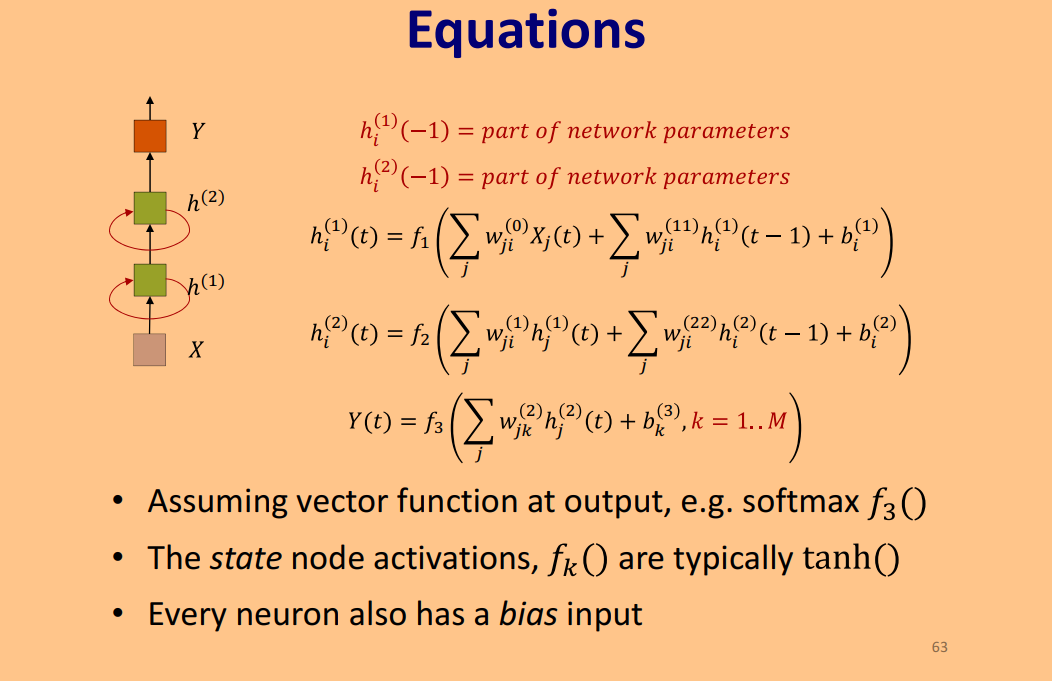

### How to Train RNN - Backprop Through Time, or BPTT

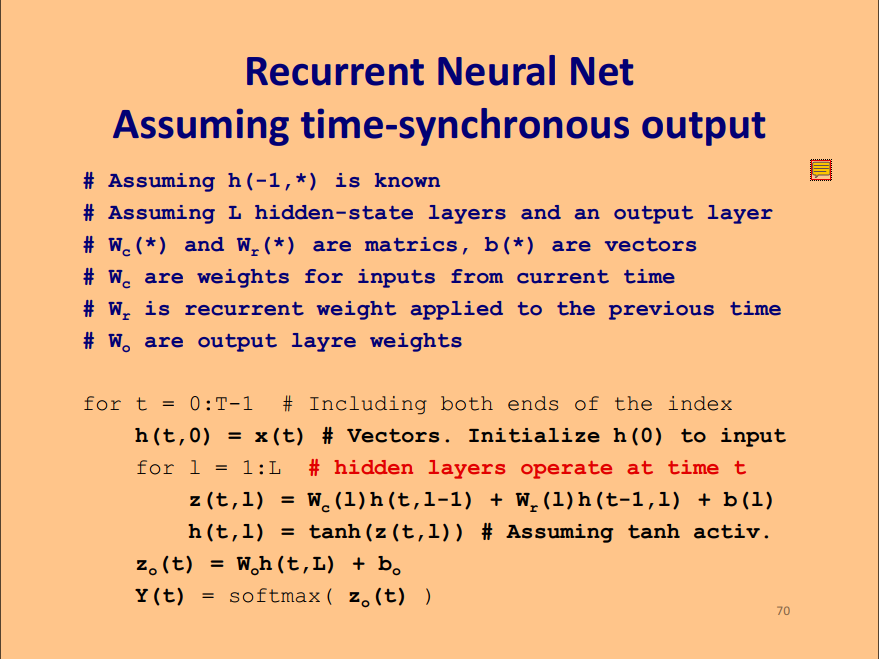

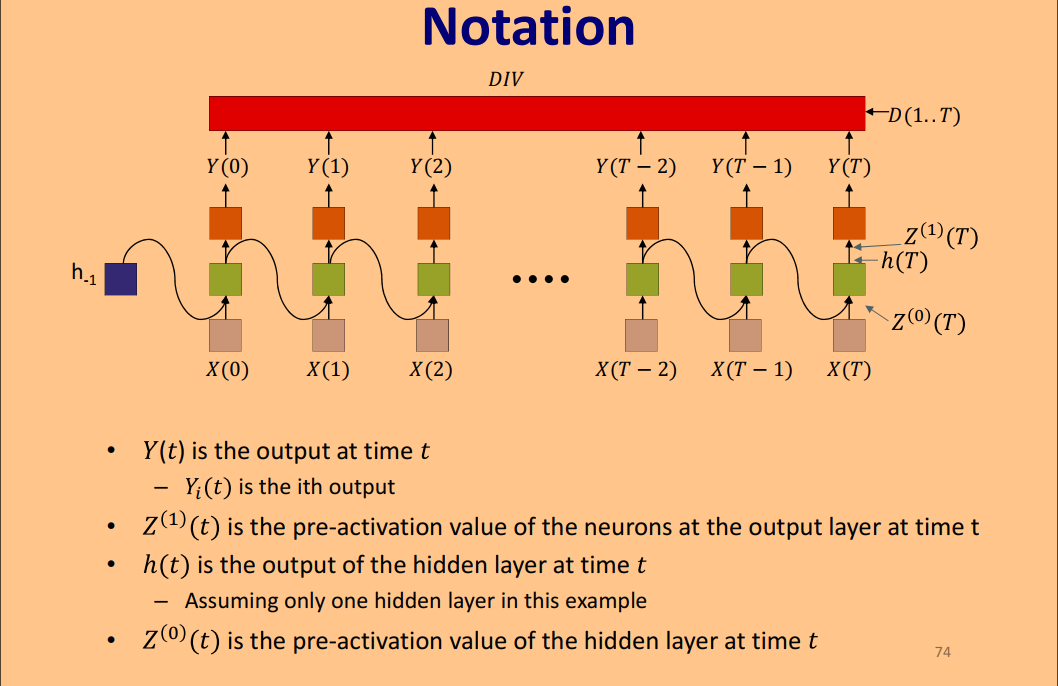

Start with $dY(t)$, trickle down to $dz$, $dW$, $db$ and $dh$ **going back in time for each layer** (hence the name BPTT).

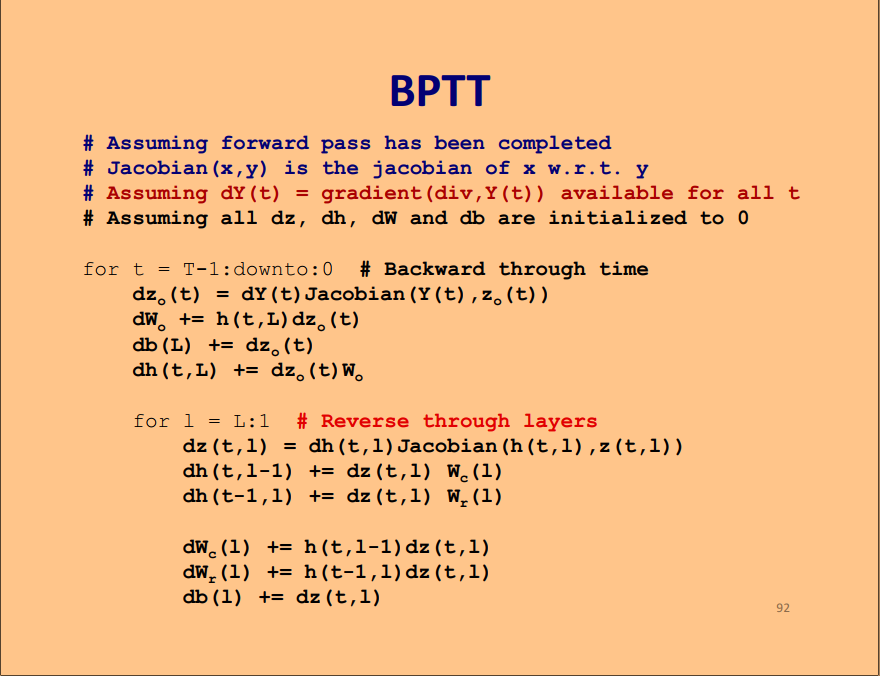

### Variants and Generalizations

#### BiDirectional RNN

Bidirectional RNN is used when it makes sense to look at the entire inputs for all the output, i.e. when there is no causal or time relationship. So we can look at the future. It works as follows.

- The forward net process the data from $t=0$ to $t=T$. **Only computing the hidden states**, initially.

- The backward nets processes the input data in reverse time, end to beginning. Initially **only the hidden state values are computed**. Clearly, this is not an online process and requires the entire input data, and this is not the backward pass of backprop. The implementation trick here is to just flip both the inputs and outputs and run the forward pass code to generate the back network. Same trick can be used in BPTT.

- The computed states of both networks are used to compute the final output at each time.


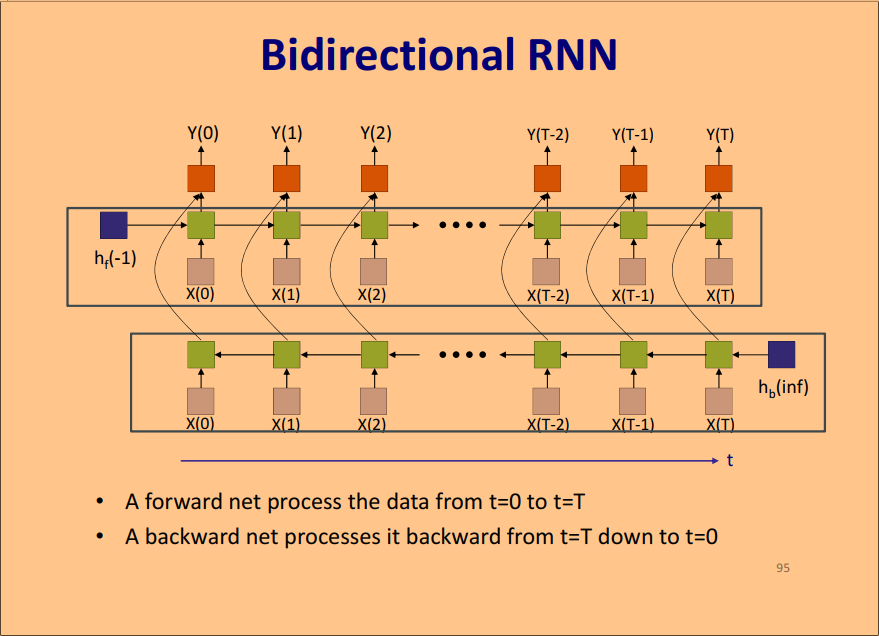

#### Long Short Term Memory (LSTM)

Each LSTM component is with the following components:

- **forget gate** $f_t$: sigmoidal unit to determine whether to carry over the history or to forget it.
- **input gate** $i_t$: sigmoidal unit to determine how much past memory to remember, and a tanh to determine whether there is something interesting in the inputs that worths remembering
- **output gate** $o_t$: sigmoidal gate to determine how current memory (subject to a tanh) produces the current state
- **constant error carousel** $C_t$: memory carried through without being affected by weights and activation, only by gates; see discussion of the disadvantage of generic RNN below.
- **state variable** $h_t$: used in the next iteration and determined by the current memory $C_t$
- **peephole connection**: the design that the input gate, forget gate and output gate depend on past or current memory.

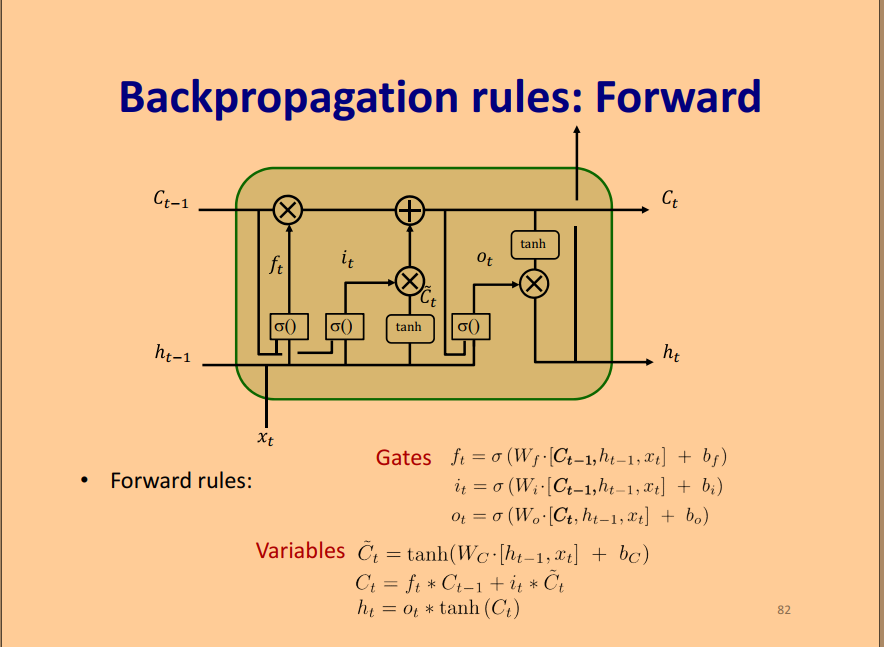

The implementation trick for LSTM is to treat each LSTM as a cell, which can be connected horizontally to form the the network across time, as well as vertically to increase the depth of at each time step, in the same way as generic RNN. Again note that it is shared parameter network - so in terms of implementation, it is beneficial to make the parameters static variables, for instance. 

This also provides abstraction in forward and backward path: as long as the inputs and outputs to the cell are sorted out, they are just the output or inputs to other cells in forward and backward path. In what follows, the forward and backward procedure of the cells naturally lead to that of the network.

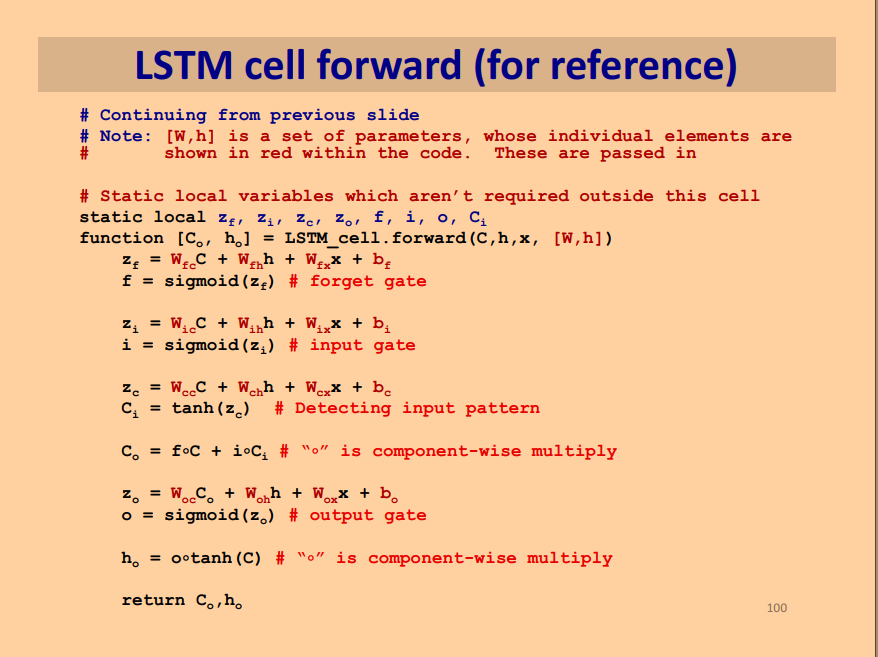

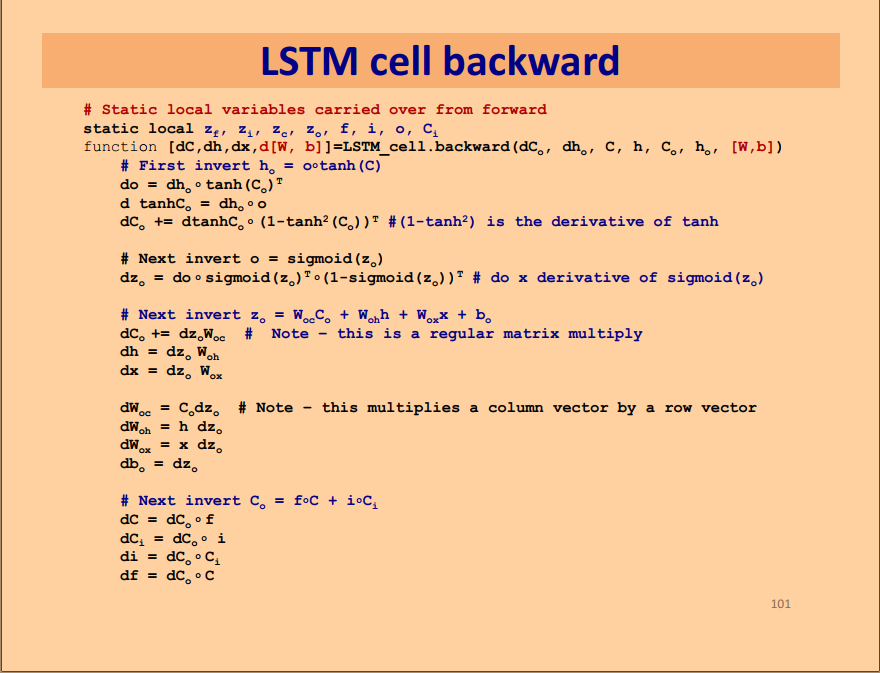

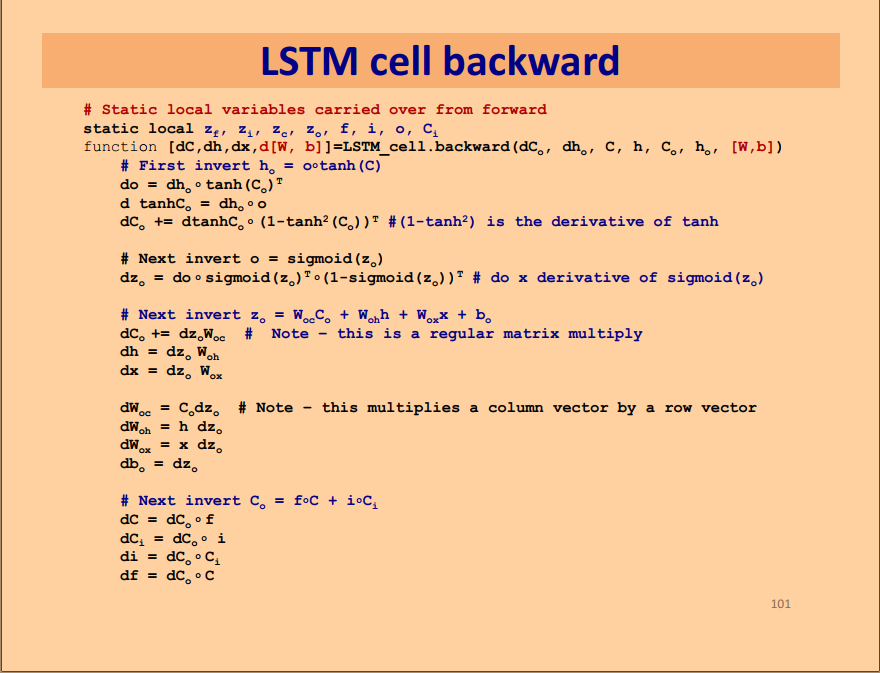

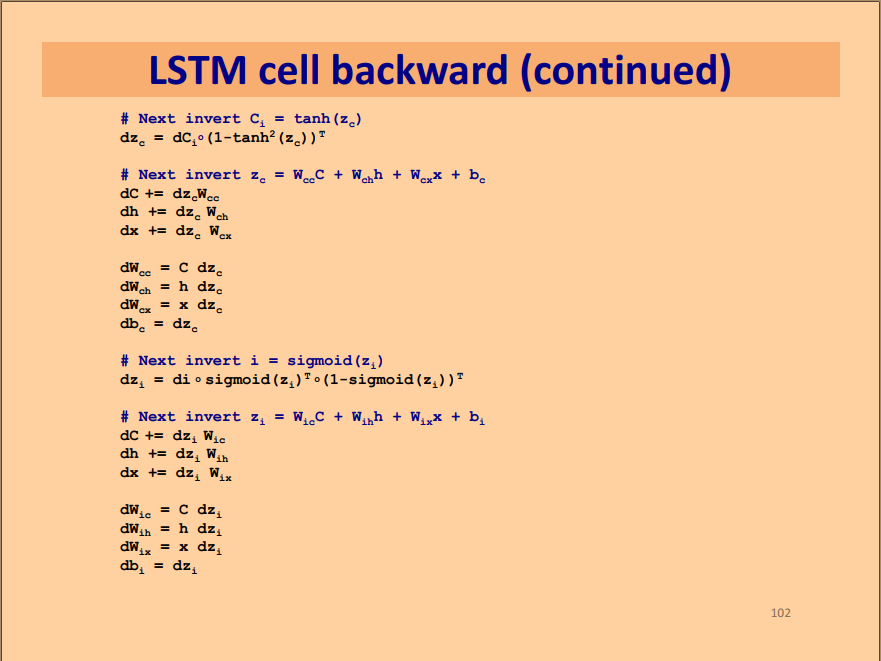

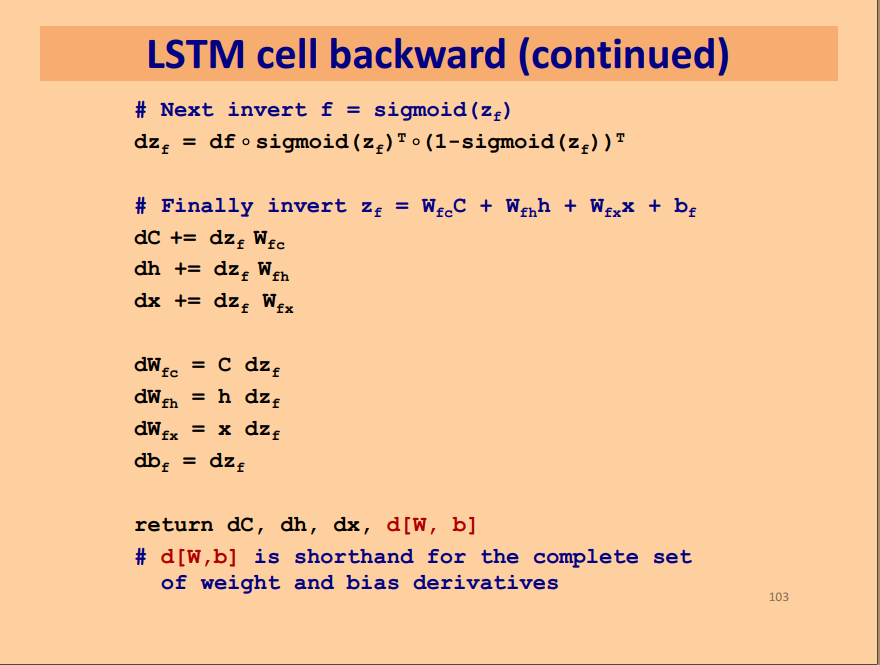

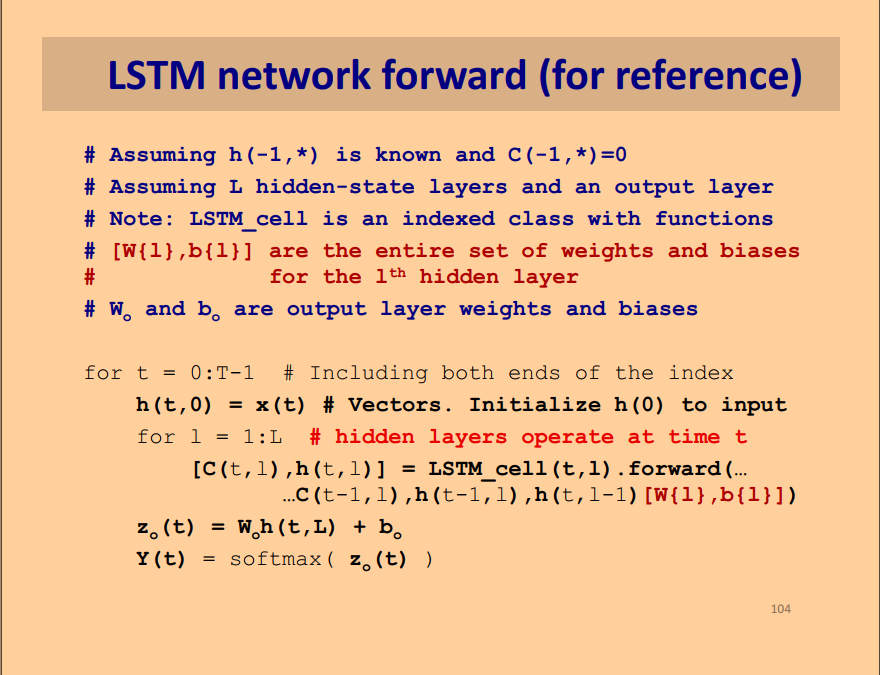

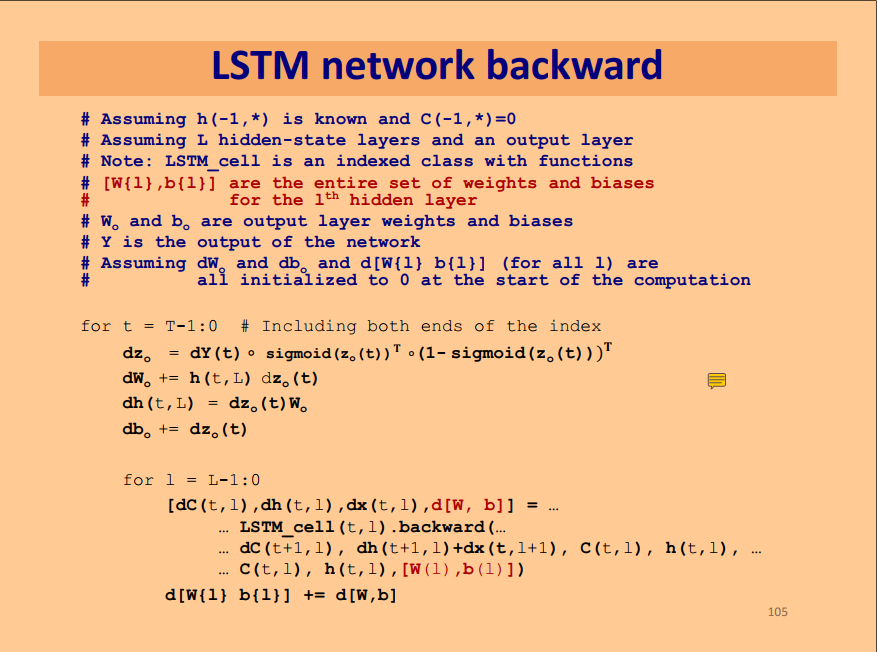

#### Gated Recurrent Units: GRU - Simplification of LSTM

- Combines the input and forget gates
- Do not separate the memory and the hidden state: they conceptually serve the same function any way!

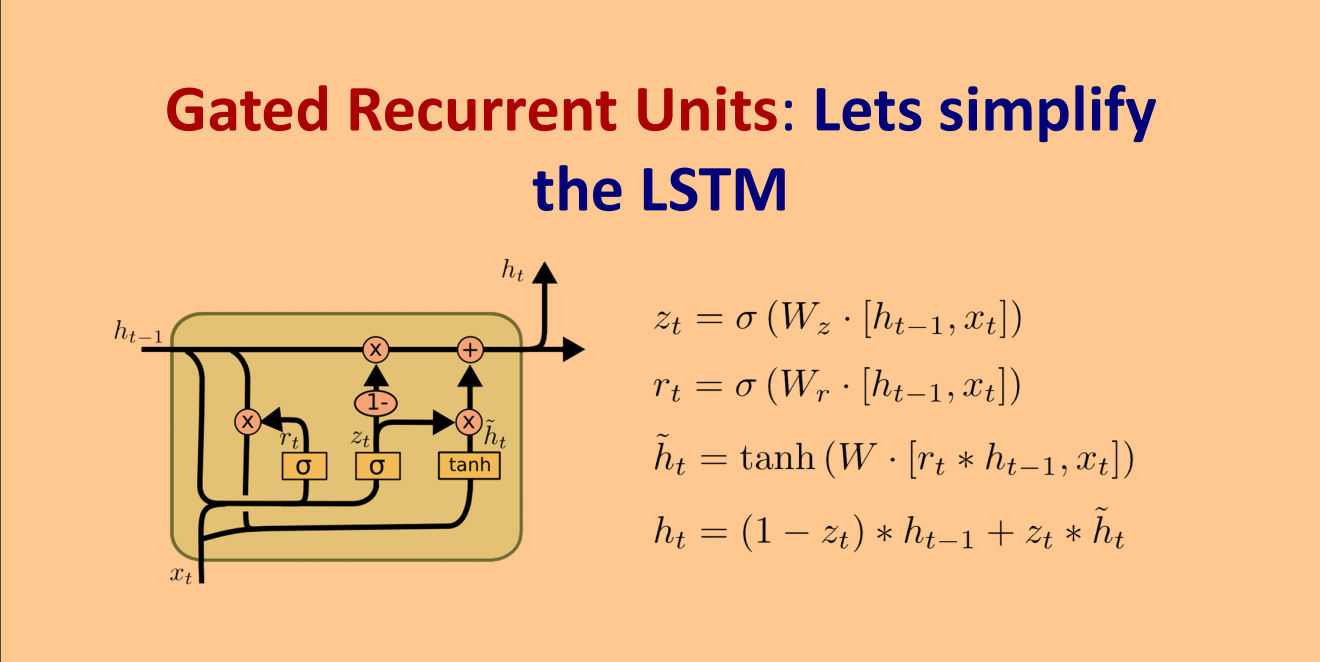

#### Sequence-to-sequence models

Depending on the application, there are many archetectures of recurrent network, when the problem involves some sort of language of speech. Many of them actually can be efficiently dealt with by simple MLP or time-decay CNN, such as the one to one and the many to one problems below.

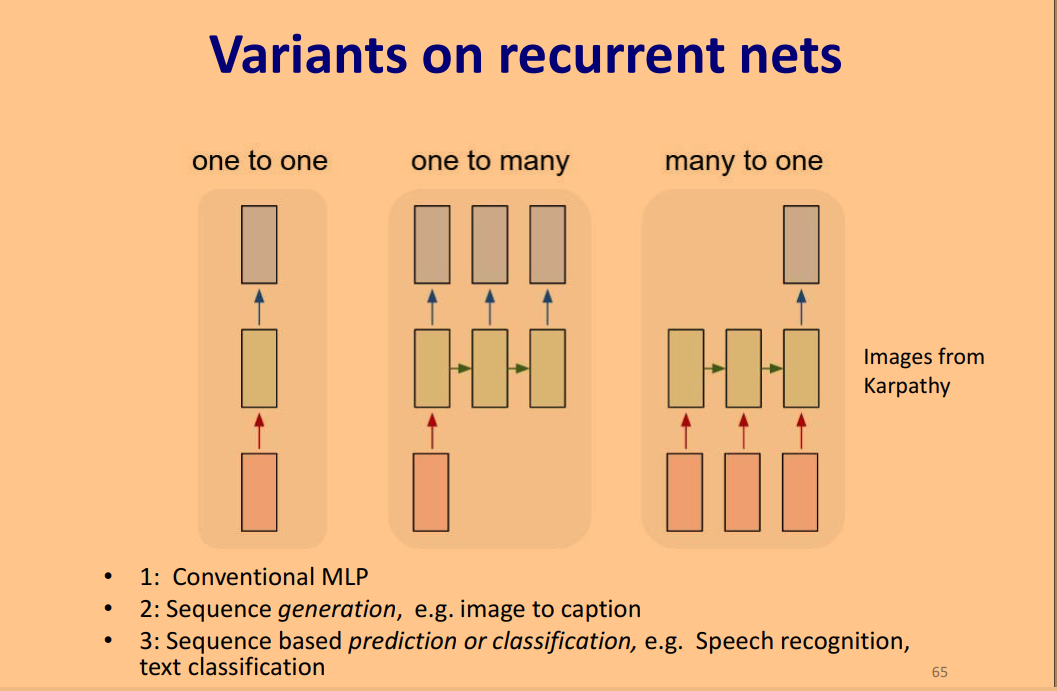

But others involves a language model, such as the following problems.

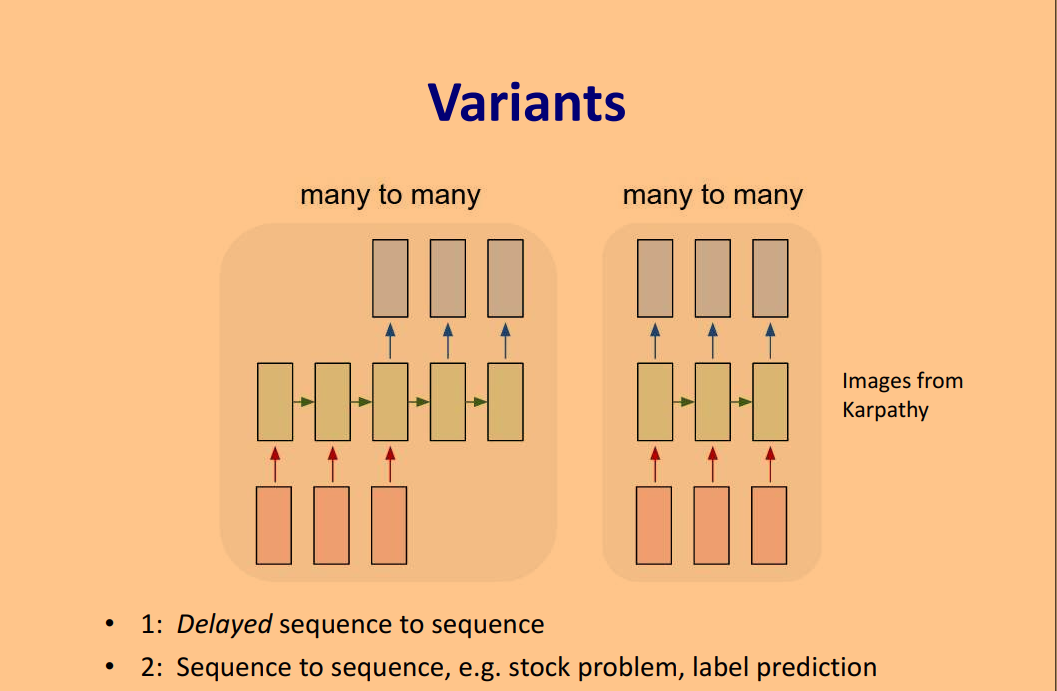

Some very brief descriptions of such models are as follows (more details can be found in Lec 14 and 15 of the CMU course).

- **Connectiontionist Temporal Classification (CTC)**
  > This model deals with problems that the output is asynchroneous as inputs, but is order synchroneous, e.g. speech to text translation - more commonly known as speech recognition (will use this as an example from now on). 
  
  > CTC seek to produce the word in the text sequence as well as the 'alignment' (a.k.a. how long does it last in the speech). Apparantly learning the word sequence and the alignment depend on each other, and the approach by CTC is similar to EM. That is, training is performed by iteratively estimating the alignment by Viterbi-decoding (a path-search algorithm, since certain words can only be followed by certain words, hence this can be formulated as a directed graph in the word space) and time-synchronous estimation of words (given the alignment).
  
  > A special 'blank' character (or other special character) needs to be introduced, to differentiate the decoding of, for instance, 'ROD' and 'ROOD'.
  
  > CTC tends to find the sub-optimal solution that is most likely time-synchronous output sequence, which is not necessarily the most likely order-synchronous sequence.
  
  > Another comment about 'BEAM Search'. In optimizing for alignments, the search tree (or graph) in the word space can quickly explode (imagine there are 30 words in a sentence, and each word can be followed by 3-4 other words - the branches can quickly exponentially increase). As such, some pruning is needed. Beam search is one such searching with pruning, whereby only the most probably few branches are retained and are allowed to 'grow'.

- **Attention Models**

  > Attention model deals with problems where there are no time-synchronousness between inputs and outputs, such as machine translation (will use this as an example now). 
  
  > Attention model is an extension of the **encoder-decoder model**, whereby the input sequence feed into an recurrent structure to encode information into a hidden state, and the last hidden state becomes the input to a second RNN of a language model to generate the output sequence. But the drawback of the encoder-decoder model is the bottleneck of the last hidden state, i.e. all hope hinges on it capturing all relevant information.
  
  > The attention model gets around this problem by computing a weighted combination of all the hidden states in the encoder for the decoder output at different time step, whereby weights varies according to the timestep in the output model depending on the hidden state in the output.
  
  > In the famous paper 'Attention is All You Need', the authors even go as far as claiming attention alone can lead to superior performance, without the RNN (which suffers from vanishing gradient problem anyway). This is called the **transformer** structure.

## Theoretical Properties

### Advantages

Recurent Neural networks are good for analyzing time series data with long-term dependence on the past, contrary to time-decay CNN (mentioned below).

RNN can also be the alternative formulation that solves the problem at hand easier than static structure; see an example of adding two N-bit numbers to produce a potentially N+1-bit number in the CMU course Lecture 12.

### Disadvantages

- The most generic form of RNN does not process the 'Bounded Input Bounded Output' stability if activation is **unbounded**, e.g. ReLu. This is because the same weight and activation is used in every time-step, and unbounded activation in states (in the generic RNN, states are just simply previous output) will very easily explode the states and the output. But then see next point...
- The most generic form of RNN can have gradients vanishing (saturate) or exploding during training. Note that the piling on of weight transform (multiplying weight matrices) makes it more likely to vanish, since the eigen vectors of these matrices may not be of the same direction; see discussion in Lecture 12 of the CMU course. 

As such, in linear systems, long-term behavior depends entirely on the eigenvalues of the hidden-layer weights matrix, but not the inputs. But even with non-linear activations, it is found that 'memory' eventually gets lost. This is actually not confined to RNN, but also all deep network structure. In RNN, this 'forgetting' not only happens vertically (how many layers an RNN has), but also horizontally (how many time steps an RNN has).

All these motivates LTSM and GRU's memory or hidden state units, which are not subject to application of weights and nonliner activation (as opposed to, say MLP, where each layer is activated before passing on to the next) and hence does not suffer from the vanishing or exploding effect of the Jacobian resulting from the activation functions when training the network. This kind of structure is called the the **constant error carousel**.

### Relation to Other Models

RNN can be viewed as a nonlinear time-series model, where there are many alternative models.

- **Time-decay CNN**: $Y_t = f(X_t, ..., X_{t-m})$. It only has finite memory, and implicitly assumes the relation between inputs and outputs are static.

- The **NARX network**, or nonlinear autoregressive network with exogenous inputs: $Y_t = f(X_{0:t}, Y_{0:t-1})$. By allowing past outputs to be passed back, it conceptually allows for infinite memory.

- **Memory models**, introducing an explicit memory variable whose job is to remember: $m_t=r(y_{t-1}, h_{t-1}, m_{t-1})$, $h_t=f(x_t, m_t)$, $y_t=g(h_t)$. Models of this sort include the following, which are considered 'partially recurrent' since learning current error does not actually propagate to the past.
    - **Jordan Network**: memory unit simply retains a running average of past outputs, with something similar to the AR(1) model. But it is a fixed structure and does not learn to remember or forget.
    - **Elman Network**: the weight from the memory unit to the hidden state is learnable, but from the hidden state to the memory unit is the "1" link.
    
- The **State-Space** model: $h_t=f(x_t, h_{t-1})$, $y_t=g(h_t)$. Although from the recursion it seems State-Space is a special case of the memory models above, State-Space represented here actually has fully learnable parameters, thus is considered a fully recurrent network. The state can be arbitrarily complex. Thus Kalman filter is probably a special case, as well as simple  RNN. 



## Empirical Performance

### Advantages and Disadvantages

RNNs represent a class of non-linear time-series models, which may be good alternatives to the traditional ARIMA models.

The LSTM/GRU models can also let the data/model determine how memory is retained/forgot automatically, which can be handy in some applications.

## Implementation Details and Practical Tricks

In [1]:
# Common imports
import numpy as np
import os

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [2]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

In [3]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

#### Fighting unstable gradients

The discussion above that generic RNN not able to retain memory very well (which LSTM and GRU partly alleviate) can be viewed as the symptom from the unstable gradients problems as with other deep nets. Many of the tricks we used in deep nets to alleviate the unstable gradients problem can also be used for RNNs: good parameter initialization, faster optimizers, dropout, batch/layer normalization, and so on.

- **parameter initialization**: in `keras`, this can be done by setting the arguments `kernel_initializer`, `recurrent_initializer` and `bias_initializer` in the constructor of the RNN cell class (see below also for how a cell works and how a custom cell is defined). But no examples can be found, so not sure if custom initialization can be done. The default for the `LSTMCell` according to the source code as of Dec 11, 2019, is `kernel_initializer='glorot_uniform'`, `recurrent_initializer='orthogonal'`, `bias_initializer='zeros'`.

- **faster optimizers**: it can be specified using the optimizer object, passed in when model compiles.

- **dropouts**: this can be done by changing the proportion `dropout` and `recurrent_dropout` in the constructor.

- **batch normalization**: Batch Normalization cannot be used as efficiently with RNNs as with deep feedforward nets. It is technically possible to add a BN layer to a memory cell (as we will see shortly) so that it will be applied at each time step (both on the inputs for that time step and on the hidden state from the previous step). However, the same BN layer will be used at each time step, with the same parameters, regardless of the actual scale and offset of the inputs and hidden state. In practice, this does not yield good results - it was slightly better than nothing when applied between recurrent layers (i.e., vertically), but not between time-steps (i.e., horizontally). But in general, do not expect too much and we are not showing an example here.

- **layer normalization**: it is very similar to Batch Normalization, but instead of normalizing across the batch dimension (for each feature across examples in the batch), it normalizes across the features dimension (for each example across all its features). **One advantage is that it can compute the required statistics on the fly, at each time step, independently for each instance**. This also means that it behaves the same way during training and testing (as opposed to BN depending on the batch), and it does not need to use exponential moving averages to estimate the feature statistics across all instances in the training set. Like BN, Layer Normalization learns a scale and an offset parameter for each input. In an RNN, it is typically used right after the linear combination of the inputs and the hidden states. See more discussion [here](https://mlexplained.com/2018/01/13/weight-normalization-and-layer-normalization-explained-normalization-in-deep-learning-part-2/). The implementation details for layer normalization can be found below.

`keras` offers a `TimeDistributed` layer, which wraps any layer (e.g., a `Dense` layer) and applies it at every time step of its input sequence; see the example of `lstm_model` below. It does this efficiently, by reshaping the inputs so that each time step is treated as a separate instance (i.e., it reshapes the inputs from $[batch size, time steps, input dimensions]$ to $[batch size × time steps, input dimensions]$.

But actually, the `Dense` layer supports sequences as inputs (and even higher-dimensional inputs): it handles them just like `TimeDistributed(Dense(…))`, meaning it is applied to the last input dimension only (independently across all time steps). Thus, we could replace the last layer in the `lstm_model` below with just `Dense(10)`.

In [ ]:
# All kinds of RNN models

np.random.seed(42)
tf.random.set_seed(42)

simple_rnn_model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1]) # the first element is None, indicating user does not know the dimension and is inferred.
])

deep_rnn_model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]), # let return_sequence is True if you want output every time step.
    keras.layers.SimpleRNN(20, return_sequences=True), 
    keras.layers.SimpleRNN(1)
])

lstm_model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]), # this is the LSTM layer, to constrast with LSTM cells
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(1))
])

gru_model = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]), # this is the GRU layer, to constrast with GRU cells
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model = gru_model #deep_rnn_model #simple_rnn_model#lstm_model#

optimizer = keras.optimizers.Adam(lr=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
  32/7000 [..............................] - ETA: 12:01

In [ ]:
model.evaluate(X_valid, y_valid)

In [ ]:
# diagonstic about training
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [ ]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

The following shows how to add **layer normalization** in RNN, and more importantly, **custom-made RNN layers/memory-cells**. The custom memory cell is just like a regular layer, except its `call()` method takes two arguments: the `inputs` at the current time step and the hidden `states` from the previous time step. Both `inputs` and `states` are arguments to the `call` method of `SimpleRNN` and `keras.layer.LSTMCell` and `keras.layer.GRUCell`.  Note that the `states` argument is a list containing one or more tensors. In the case of a simple RNN cell it contains a single tensor equal to the outputs of the previous time step, but other cells may have multiple state tensors. A cell must also have a `state_size` attribute and an `output_size` attribute. In a simple RNN, both are simply equal to the number of units, again because its states are simply previous outputs.

In [6]:
from tensorflow.keras.layers import LayerNormalization

In [ ]:
class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units,
                                                          activation=None)
        self.layer_norm = LayerNormalization()
        self.activation = keras.activations.get(activation)
    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        if inputs is not None:
            batch_size = tf.shape(inputs)[0]
            dtype = inputs.dtype
        return [tf.zeros([batch_size, self.state_size], dtype=dtype)]
    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

You can define RNN layers as a whole as shown above, or you can pass in the cell type in the constructor of the generic `keras.layers.RNN` as shown below, which is also the way to make a layer of custom cells.

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True,
                     input_shape=[None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

## Use Cases

Time series modeling

## Results Interpretation, Metrics and Visualization

## References 

- CMU Deep Learning Course Fall 2019, Lectures 11-15
- < Hands-on Machine Learning >, Chapter 15

### Further Reading

- [A pruning based method to learn both weights and connections for LSTM](https://www.evernote.com/shard/s191/nl/21353936/9e85fe2b-48e2-4992-8b06-941ee59c28cd?title=A%20pruning%20based%20method%20to%20learn%20both%20weights%20and%20connections%20for%20LSTM)

## Misc.